<a href="https://colab.research.google.com/github/Imartinezcuevas/RL_MC_OL/blob/main/Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q-Learning con Políticas epsilon-soft
Este notebook describe un experimento de aprendizaje por refuerzo utilizando el algoritmo de Monte Carlo con políticas epsilon-soft. El propósito de este análisis es entrenar un agente en un entorno de gym con el juego "FrozenLake", un entorno estándar en el que el agente debe aprender a moverse a través de un mapa en busca de una meta, evitando caer en agujeros. A continuación, se presenta una descripción de las diferentes partes del código y el proceso utilizado en el experimento.

## Preparación del entorno
La preparación consta de las siguientes partes:

* **Instalación de Dependencias**: Se instalan las librerías necesarias para utilizar el entorno gymnasium para la simulación, con el objetivo de crear un ambiente controlado para que el agente pueda interactuar.

* **Importación de Librerías**: Se importan las bibliotecas necesarias como numpy para el manejo de matrices y matplotlib para la visualización de los resultados.

* **Importación del Entorno "FrozenLake"**: Se cargan dos versiones del entorno "FrozenLake": una de 4x4 y otra de 8x8. Ambas versiones no son resbaladizas, lo que facilita la comprensión de los resultados, dado que el entorno resbaladizo podría dificultar la comprensión inicial del aprendizaje.

In [1]:
#@title Copiar el repositorio.

!git clone https://github.com/Imartinezcuevas/RL_MC_OL.git
!cd k_brazos_MC_OL/

fatal: destination path 'RL_MC_OL' already exists and is not an empty directory.
/bin/bash: line 1: cd: k_brazos_MC_OL/: No such file or directory


In [2]:
#@title Importamos todas las clases y funciones

%%capture
#@title Instalamos gym
!pip install 'gym[box2d]==0.20.0'

## Instalación de algunos paquetes.
#!apt-get update
## Para usar gymnasium[box2d]
#!apt install swig
#!pip install gymnasium[box2d]

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/RL_MC_OL/src')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
from typing import List

from agentes import Agent, TabularAgent, QLearningAgent
from politicas import Policy, EpsilonGreedyPolicy
from plotting import plot_reward_ratio, plot_episode_lengths

In [12]:
#@title Importamos escenarios
name = 'FrozenLake-v1'
env4 = gym.make(name, is_slippery=False, map_name="4x4", render_mode="ansi") # No resbaladizo para entender mejor los resultados.
env8 = gym.make(name, is_slippery=False, map_name="8x8", render_mode="ansi") # No resbaladizo para entender mejor los resultados.
env_taxi = gym.make('Taxi-v3', render_mode="ansi")

## 2. Diseño del Agente
El diseño del agente consta de dos partes, el algoritmo con el que aprende y las políticas (toma de decisiones) que realiza.

* **Políticas del Agente**

  * **Política epsilon-soft**: Se define una política donde todas las acciones tienen una probabilidad de ser elegida.
  * **Política epsilon-greedy**: basada en la política epsilon-soft. De esta forma el agente tiene una pequeña probabilidad de explorar (tomar una acción aleatoria) y una mayor probabilidad de explotar (tomar la acción que considera mejor). Esto permite equilibrar la exploración y la explotación.
  * **Política greedy**: Es la usada una vez que "ha aprendido".

* **Algoritmo de Iteración de Valor**

  * Se implementa el algoritmo de iteración de valor utilizando Monte Carlo.
  * Se usa una versión "on-policy" de Monte Carlo con políticas epsilon greedy sobre una política epsilon-soft.
  * Se basa en el criterio de todas las visitas.
  * Otro aspecto es que la actualización de los retornos se realiza en el orden inverso a las visitas.

  Para la creación del agente se ha declarado una clase como en el ejemplo de las diapositivas:

  * Se ha creado una clase base para todos los agentes con los metodos básicos como __init__, get_action y update.
  * Para los algoritmos tabulares se ha implementado la clase TabularAgent que guarda la tabla Q.
  * Dentro de los algoritmos tabulares se ha implementado Monte Carlo: On-Policy y Off-policy. Los dos comentados en este notebook.

## 3. Función de entrenamiento
Se ha modificado el bucle utilizado como referencia para poder usar los agentes desarrollados.

* El agente es el que tiene la política. Así facilitamos la modularidad y podemos explorar más opciones en el futuro.
* El agente es quien mantiene todos los datos: episodios, recompensas, transiciones, estadísticas, etc

In [4]:
def evaluate_agent(agent, env, num_episodes=100):
    success_count = 0
    episode_lengths = []
    total_rewards = []

    # Guardamos el valor original de epsilon
    original_epsilon = agent.policy.epsilon

    # Establecemos epsilon a 0 para evaluación determinista
    agent.policy.epsilon = 0.0

    for _ in range(num_episodes):
        state, _ = env.reset(seed=100)
        done = False
        steps = 0
        episode_reward = 0
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            steps += 1
            episode_reward += reward
            state = next_state
            if terminated and reward > 0:
                success_count += 1
        episode_lengths.append(steps)
        total_rewards.append(episode_reward)

    # Restauramos el valor original de epsilon
    agent.policy.epsilon = original_epsilon

    success_rate = success_count / num_episodes
    avg_episode_length = np.mean(episode_lengths)
    avg_reward = np.mean(total_rewards)
    return success_rate, avg_episode_length, avg_reward

In [5]:
# Función de entrenamiento
def train_qlearning(agent, env, num_episodes=50000, decay=False, decay_alpha=False, max_step_per_episode=1000):
    evaluation_history = []
    step_display = num_episodes / 10

    for episode in tqdm(range(num_episodes)):
        state, info = env.reset(seed=100)
        agent.start_episode()  # Inicia el episodio para el agente

        done = False
        step = 0
        episode_reward = 0

        while not done and step < max_step_per_episode:
            # Obtiene la acción usando la política
            action = agent.get_action(state)

            # Ejecuta el paso en el entorno
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # Actualiza el agente con la transición
            agent.update(state, action, next_state, reward, done, info)

            episode_reward += reward
            state = next_state  # Actualiza el estado
            step += 1

        # Guarda las estadísticas del episodio
        agent.end_episode(episode_reward, step)

        # Aplica el decaimiento de alpha al inicio de cada episodio
        if decay_alpha:
            agent.decay_learning_rate()

        # Si decay es verdadero, ajusta epsilon
        if decay:
            agent.policy.decay_epsilon()

        # Muestra la evolución cada cierto número de episodios
        if episode % step_display == 0 and episode != 0:
          success_rate, avg_length, avg_reward = evaluate_agent(agent, env, num_episodes=100)
          print(f"\nPorcentaje de éxito: {success_rate}, Longitud media del episodio: {avg_length}, Recompensa media: {avg_reward}")
          print(f"Epsilon actual: {agent.policy.epsilon:.4f}, alpha actual: {agent.alpha:.4f}")
          evaluation_history.append((episode, success_rate, avg_length, avg_reward))

    return agent

## FrozenLake - 4x4

 10%|█         | 5132/50000 [00:08<00:47, 941.34it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.3115, alpha actual: 0.2336


 21%|██        | 10346/50000 [00:11<00:23, 1656.89it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.2426, alpha actual: 0.1819


 30%|███       | 15238/50000 [00:14<00:21, 1633.73it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.1889, alpha actual: 0.1417


 41%|████      | 20358/50000 [00:16<00:16, 1811.23it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.1471, alpha actual: 0.1104


 50%|█████     | 25149/50000 [00:20<00:22, 1097.88it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.1146, alpha actual: 0.0859


 60%|██████    | 30194/50000 [00:22<00:11, 1723.58it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.0892, alpha actual: 0.0669


 71%|███████   | 35332/50000 [00:25<00:08, 1810.30it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.0695, alpha actual: 0.0521


 81%|████████  | 40255/50000 [00:28<00:05, 1799.89it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.0541, alpha actual: 0.0406


 91%|█████████ | 45355/50000 [00:30<00:02, 1836.85it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.0422, alpha actual: 0.0316


100%|██████████| 50000/50000 [00:34<00:00, 1467.83it/s]


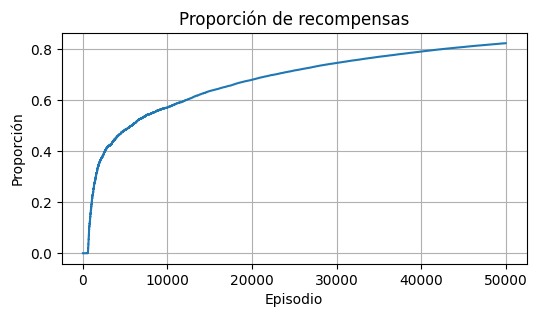

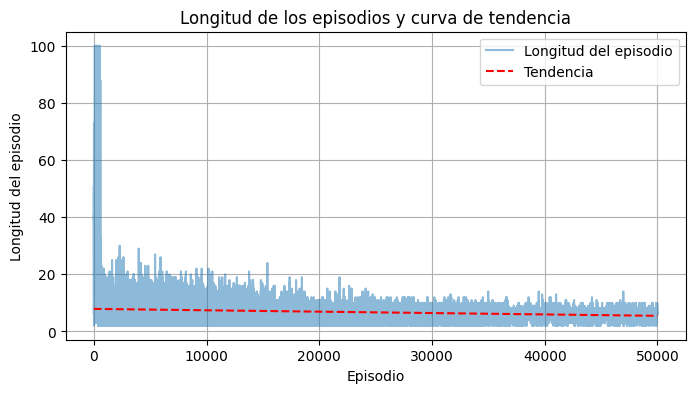

In [6]:
# Crear la política con epsilon 0.4
epsilon_policy = EpsilonGreedyPolicy(env4.action_space, epsilon=0.4, epsilon_decay=0.99995, epsilon_min=0.01)

# Crear el agente usando MonteCarloOnPolicyAgent y la política
agent_env4 = QLearningAgent(env4, policy=epsilon_policy, alpha=0.3, gamma=1.0, alpha_decay=0.99995, alpha_min=0.01)

# Entrenamos al agente
trained_agent_env4 = train_qlearning(agent_env4, env4, num_episodes=50000, decay=True, decay_alpha=True)

stats = trained_agent_env4.stats()

# Graficamos los resultados
plot_reward_ratio(stats["reward_ratio"])
plot_episode_lengths(stats["episode_lengths"])

In [7]:
def pi_star_from_Q(env, Q):
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, info = env.reset(seed=100) # start in top-left, = 0
    actions = ""
    while not done:
        action = np.argmax(Q[state, :])
        actions += f"{action}, "
        pi_star[state,action] = action
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    return pi_star, actions

Q = trained_agent_env4.get_action_values()
pi, actions = pi_star_from_Q(env4, Q)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env4.render())
print()

Política óptima obtenida
 [[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]] 
 Acciones 1, 1, 2, 2, 1, 2,  
 Para el siguiente grid
   (Right)
SFFF
FHFH
FFFH
HFFG




## FrozenLake - 8x8


 10%|█         | 5088/50000 [00:10<01:23, 535.07it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0164, alpha actual: 0.0164


 20%|██        | 10159/50000 [00:16<00:49, 803.17it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 30%|███       | 15115/50000 [00:21<00:44, 782.83it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 40%|████      | 20127/50000 [00:27<00:37, 790.31it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 50%|█████     | 25171/50000 [00:33<00:29, 828.74it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 60%|██████    | 30147/50000 [00:39<00:26, 759.82it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 70%|███████   | 35163/50000 [00:45<00:18, 793.13it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 80%|████████  | 40121/50000 [00:51<00:12, 787.62it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 90%|█████████ | 45163/50000 [00:57<00:06, 787.82it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, alpha actual: 0.0100


100%|██████████| 50000/50000 [01:03<00:00, 790.16it/s]


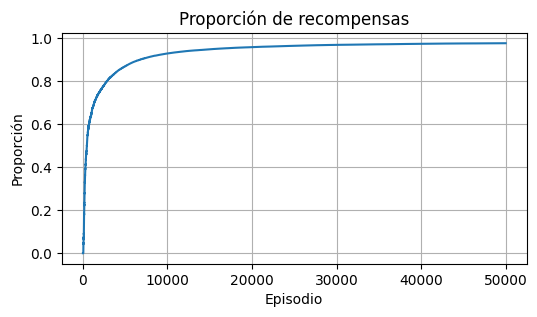

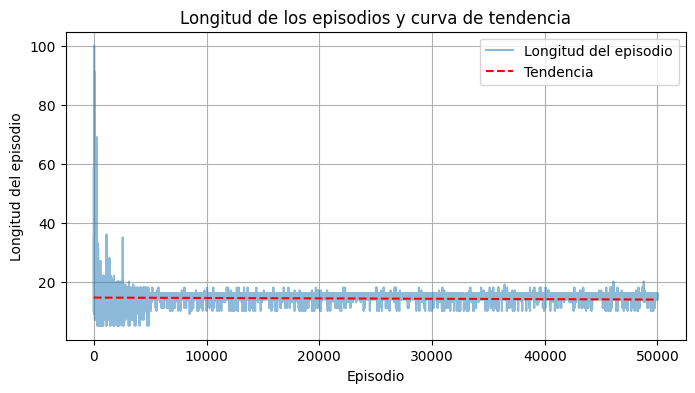

In [8]:
# Crear la política con epsilon 0.4
epsilon_policy = EpsilonGreedyPolicy(env8.action_space, epsilon=0.2, epsilon_decay=0.9995, epsilon_min=0.01)

# Crear el agente usando MonteCarloOnPolicyAgent y la política
agentEnv8 = QLearningAgent(env8, policy=epsilon_policy, alpha=0.2, gamma=0.99, optimistic_init=True, init_value=1.0, alpha_decay=0.9995, alpha_min=0.01)

# Entrenamos al agente
trained_agent_env8 = train_qlearning(agentEnv8, env8, num_episodes=50000, decay=True, decay_alpha=True)

stats = trained_agent_env8.stats()

# Graficamos los resultados
plot_reward_ratio(stats["reward_ratio"])
plot_episode_lengths(stats["episode_lengths"])

In [9]:
Q = trained_agent_env8.get_action_values()
pi, actions = pi_star_from_Q(env8, Q)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env8.render())
print()

Política óptima obtenida
 [[0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 
 Acciones 2,

## Taxi

 10%|█         | 5131/50000 [00:09<01:21, 552.63it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.1103, alpha actual: 0.0736


 20%|██        | 10063/50000 [00:17<01:36, 413.73it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0406, alpha actual: 0.0271


 30%|███       | 15071/50000 [00:24<01:04, 544.72it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0149, alpha actual: 0.0100


 40%|████      | 20130/50000 [00:32<00:46, 644.25it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 50%|█████     | 25143/50000 [00:39<00:40, 610.68it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 60%|██████    | 30089/50000 [00:46<00:34, 569.13it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 70%|███████   | 35072/50000 [00:53<00:26, 570.46it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 80%|████████  | 40093/50000 [01:01<00:15, 636.85it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0100, alpha actual: 0.0100


 90%|█████████ | 45087/50000 [01:08<00:12, 408.75it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0100, alpha actual: 0.0100


100%|██████████| 50000/50000 [01:15<00:00, 659.30it/s]


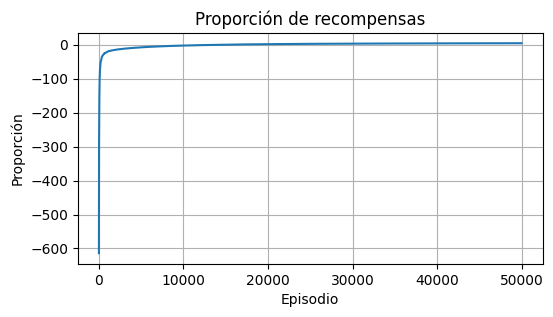

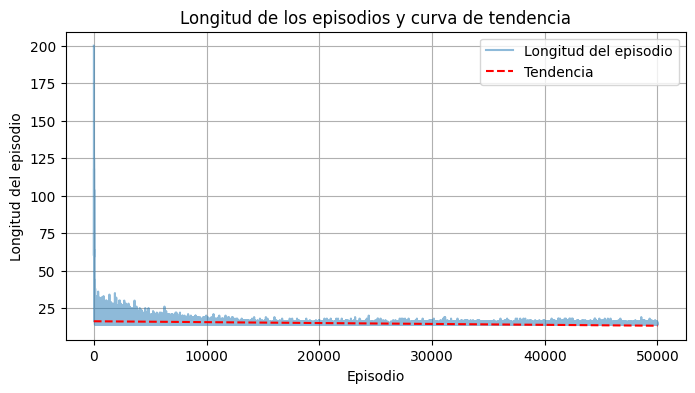

In [13]:
# Crear la política con epsilon 0.4
epsilon_policy = EpsilonGreedyPolicy(env_taxi.action_space, epsilon=0.3, epsilon_decay=0.9998, epsilon_min=0.01)

# Crear el agente usando MonteCarloOnPolicyAgent y la política
agent_taxi = QLearningAgent(env_taxi, policy=epsilon_policy, alpha=0.2, gamma=0.95, alpha_decay=0.9998, alpha_min=0.01)

# Entrenamos al agente
trained_agent_taxi = train_qlearning(agent_taxi, env_taxi, num_episodes=50000, decay=True, decay_alpha=True)

stats = trained_agent_taxi.stats()

# Graficamos los resultados
plot_reward_ratio(stats["reward_ratio"])
plot_episode_lengths(stats["episode_lengths"])

In [14]:
Q = trained_agent_taxi.get_action_values()
pi, actions = pi_star_from_Q(env_taxi, Q)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env_taxi.render())
print()

Política óptima obtenida
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 
 Acciones 1, 1, 2, 2, 2, 0, 0, 4, 1, 2, 1, 1, 1, 5,  
 Para el siguiente grid
 +---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


